In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
import os
import gdown
import tarfile

# Define the URL for the UTKFace dataset
url = 'https://drive.google.com/u/0/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk&export=download'

# Define the directory to store the dataset
data_dir = './data'

# Create the directory if it doesn't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download the tar file
filename = 'UTKFace.tar.gz'
filepath = os.path.join(data_dir, filename)
gdown.download(url, filepath, quiet=False)

# Extract the tar file
tar = tarfile.open(filepath, 'r:gz')
tar.extractall(data_dir)
tar.close()

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk&export=download
From (redirected): https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk&export=download&confirm=t&uuid=b360bbfd-0474-475c-af29-20e1ca6cf7ec
To: /Users/tharakpisara/Downloads/data/UTKFace.tar.gz
100%|████████████████████████████████████████| 107M/107M [00:31<00:00, 3.34MB/s]


In [3]:
BASE_DIR = '/Users/tharakpisara/Downloads/data/UTKFace'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/Users/tharakpisara/Downloads/data/UTKFace/9_1...,9,1
1,/Users/tharakpisara/Downloads/data/UTKFace/36_...,36,0
2,/Users/tharakpisara/Downloads/data/UTKFace/86_...,86,1
3,/Users/tharakpisara/Downloads/data/UTKFace/26_...,26,1
4,/Users/tharakpisara/Downloads/data/UTKFace/1_1...,1,1


In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

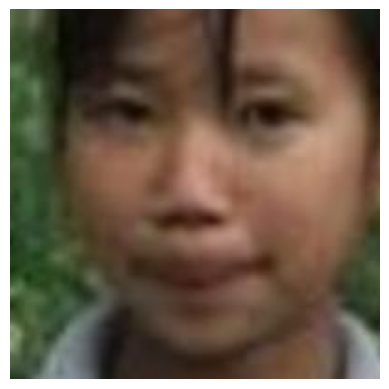

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

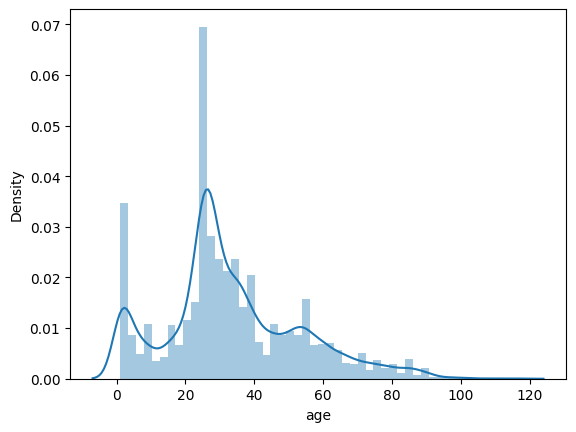

In [8]:
sns.distplot(df['age'])

In [9]:
df['gender']

0        1
1        0
2        1
3        1
4        1
        ..
23703    0
23704    0
23705    0
23706    0
23707    1
Name: gender, Length: 23708, dtype: int64

<Axes: xlabel='gender', ylabel='count'>

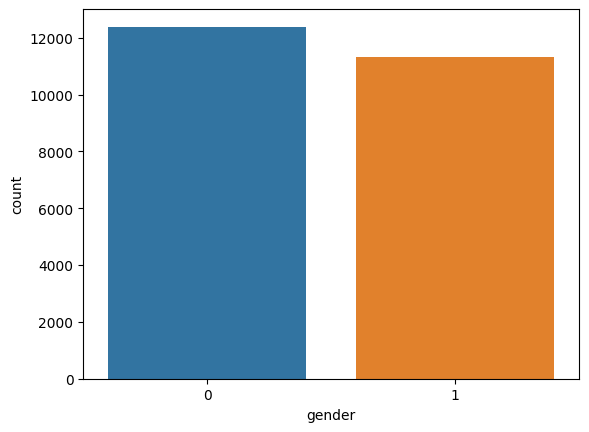

In [10]:
sns.countplot(x=df['gender'],data=df)


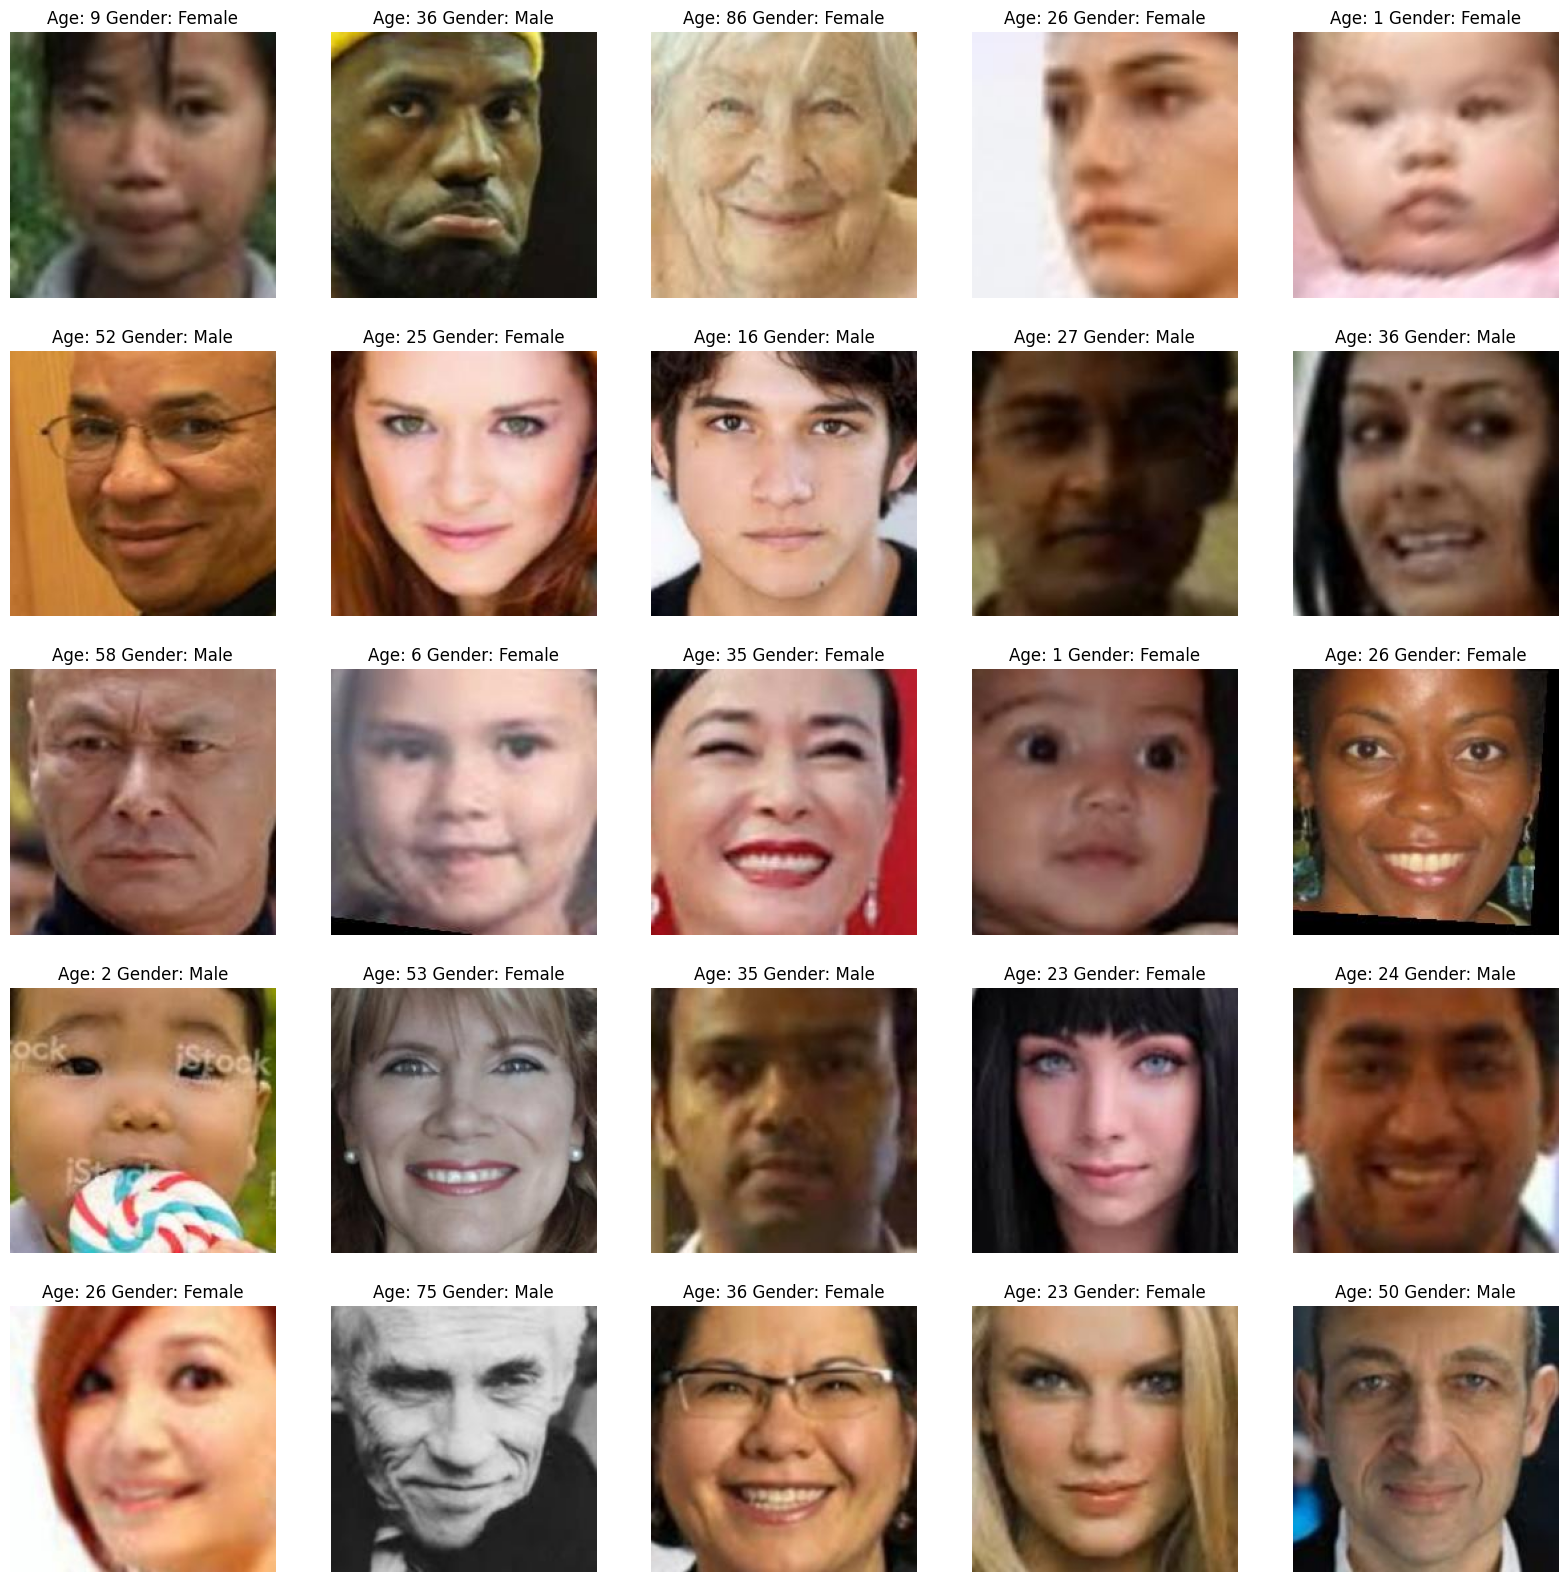

In [11]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


In [22]:
from PIL import Image
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.LANCZOS)

        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [23]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [24]:
X.shape

(23708, 128, 128, 1)

In [25]:
X = X/255.0

In [26]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [27]:
input_shape = (128, 128, 1)

In [28]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 96s 161ms/step - loss: 15.8232 - gender_out_loss: 0.6785 - age_out_loss: 15.1447 - gender_out_accuracy: 0.5522 - age_out_accuracy: 0.0463 - val_loss: 12.9253 - val_gender_out_loss: 0.5474 - val_age_out_loss: 12.3779 - val_gender_out_accuracy: 0.7275 - val_age_out_accuracy: 0.0493
Epoch 2/30
593/593 [==============================] - 102s 172ms/step - loss: 12.0684 - gender_out_loss: 0.5170 - age_out_loss: 11.5514 - gender_out_accuracy: 0.7489 - age_out_accuracy: 0.0337 - val_loss: 11.5008 - val_gender_out_loss: 0.4766 - val_age_out_loss: 11.0242 - val_gender_out_accuracy: 0.7655 - val_age_out_accuracy: 0.0162
Epoch 3/30
593/593 [==============================] - 103s 174ms/step - loss: 10.3090 - gender_out_loss: 0.4411 - age_out_loss: 9.8680 - gender_out_accuracy: 0.7927 - age_out_accuracy: 0.0187 - val_loss: 10.2620 - val_gender_out_loss: 0.4034 - val_age_out_loss: 9.8587 - val_gender_out_accuracy: 0.8218 - val_age_out_accuracy: 0.

Epoch 26/30
593/593 [==============================] - 131s 221ms/step - loss: 4.6307 - gender_out_loss: 0.1469 - age_out_loss: 4.4839 - gender_out_accuracy: 0.9364 - age_out_accuracy: 0.0042 - val_loss: 6.9995 - val_gender_out_loss: 0.3573 - val_age_out_loss: 6.6422 - val_gender_out_accuracy: 0.8804 - val_age_out_accuracy: 0.0040
Epoch 27/30
593/593 [==============================] - 132s 223ms/step - loss: 4.5476 - gender_out_loss: 0.1444 - age_out_loss: 4.4032 - gender_out_accuracy: 0.9387 - age_out_accuracy: 0.0047 - val_loss: 6.8824 - val_gender_out_loss: 0.3333 - val_age_out_loss: 6.5491 - val_gender_out_accuracy: 0.8832 - val_age_out_accuracy: 0.0040
Epoch 28/30
593/593 [==============================] - 134s 226ms/step - loss: 4.4414 - gender_out_loss: 0.1378 - age_out_loss: 4.3036 - gender_out_accuracy: 0.9415 - age_out_accuracy: 0.0050 - val_loss: 6.9901 - val_gender_out_loss: 0.3763 - val_age_out_loss: 6.6138 - val_gender_out_accuracy: 0.8834 - val_age_out_accuracy: 0.0067
E

In [32]:
from tensorflow.keras.models import save_model

save_model(model, './age_gender_model.h5')

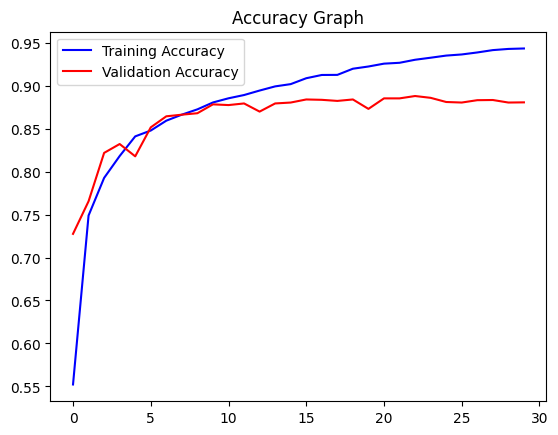

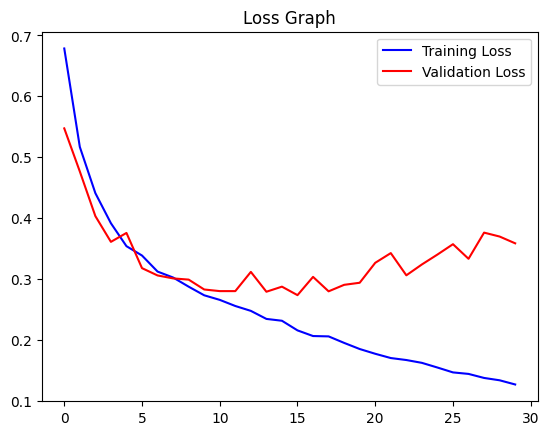

In [33]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


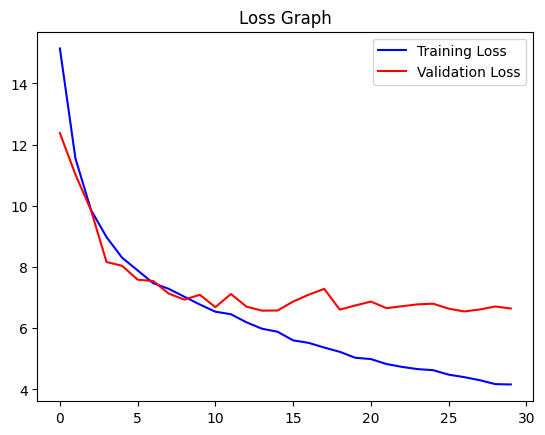

In [34]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 11
1/1 [==============================] - 0s 15ms/step
Predicted Gender: Male Predicted Age: 6


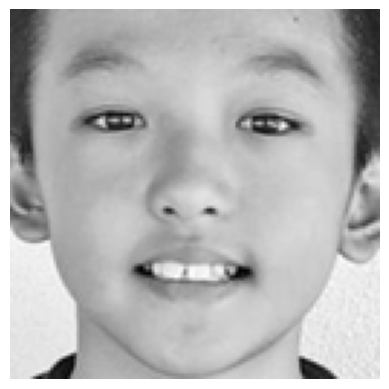

In [42]:
image_index = 23000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 25
1/1 [==============================] - 0s 14ms/step
Predicted Gender: Female Predicted Age: 25


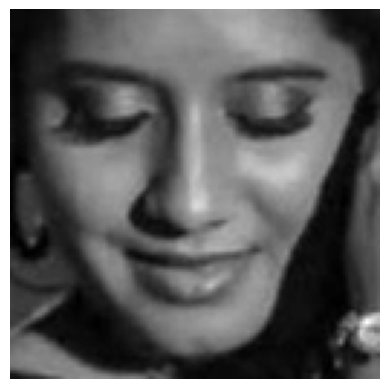

In [43]:
image_index = 7000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 48
1/1 [==============================] - 0s 17ms/step
Predicted Gender: Female Predicted Age: 52


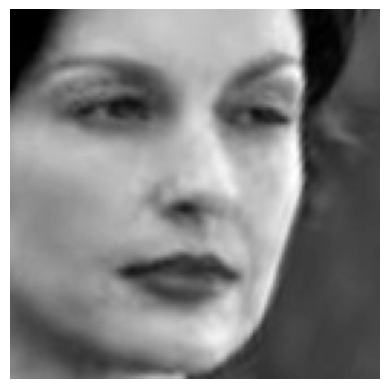

In [37]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');